In [24]:
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import glob
import numpy
import random
import pandas as pd

from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchsummary import summary

# Note: this notebook requires torch >= 1.10.0
torch.__version__

'2.5.1+cu121'

In [25]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [26]:
# import zipfile

# zip_path = os.path.join("C:/IIUM/AI Note IIUM/Deep_Learning/Week After (W9+)/data", "gender.zip")
# extract_path = "C:/IIUM/AI Note IIUM/Deep_Learning/Week After (W9+)/data/Gender"

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

In [27]:
train_dir = "C:/IIUM/AI Note IIUM/Deep_Learning/Week After (W9+)/data/Gender/Train"
test_dir = "C:/IIUM/AI Note IIUM/Deep_Learning/Week After (W9+)/data/Gender/Test"


# Get the class names from the target directory
classes = sorted([entry.name for entry in list(os.scandir(train_dir))])
print(f"Class names: {classes}")

Class names: ['female', 'male']


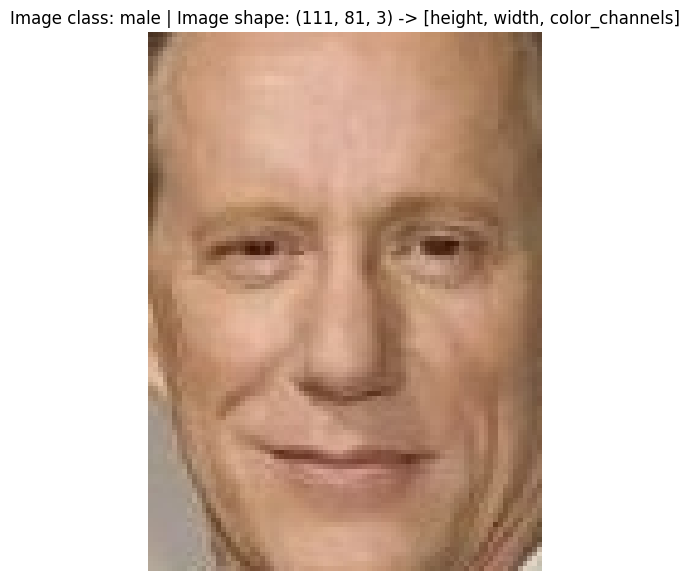

In [28]:
import pathlib
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random

# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(pathlib.Path(train_dir).glob("*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

In [29]:
from torch.utils.data import Dataset

#######################################################
#               Define Dataset Class
#######################################################

class CustomDataset(Dataset):
    def __init__(self, image_paths, transform=False): # where the images are
        self.image_paths = self.paths = list(pathlib.Path(image_paths).glob("*/*.jpg")) # note: you'd have to update this if you've got .png's or .jpeg's
        self.transform = transform

    def __len__(self): # size of dataset
        return len(self.image_paths)

    def __getitem__(self, idx): # how to get an item
        image_filepath = self.image_paths[idx]
        image = Image.open(image_filepath) # if using torchvision transforms

        # label = image_filepath.split('/')[-2]
        label = self.image_paths[idx].parent.name # expects path in data_folder/class_name/image.jpeg

        label = class_to_idx[label] # type: ignore
        if self.transform is not None:
            image = self.transform(image) # type: ignore # if using torchvision transforms

        return image, label

In [30]:
len(train_dir), len(test_dir)

(69, 68)

In [31]:
from torchvision import transforms

# Define a basic transform for the images
data_transform = transforms.Compose([
	transforms.Resize((224, 224)),
	transforms.ToTensor(),
])

# Create ImageFolder datasets for comparison if not already created
train_data = datasets.ImageFolder(root=train_dir, transform=data_transform)
test_data = datasets.ImageFolder(root=test_dir, transform=data_transform)

# Check for equality amongst our custom Dataset and ImageFolder Dataset
print((len(train_data) == len(train_data)) & (len(test_data) == len(test_data)))

True


In [32]:
#######################################################
#                  Create Dataloader
#######################################################

# Turn train and test custom Dataset's into DataLoader's
from torch.utils.data import DataLoader
train_dataloader_custom = DataLoader(dataset=train_data, # use custom created train Dataset
                                     batch_size=128, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

test_dataloader_custom = DataLoader(dataset=test_data, # use custom created test Dataset
                                    batch_size=128,
                                    num_workers=0,
                                    shuffle=False) # don't usually need to shuffle testing data


In [33]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 3.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, 3)

# LOSS AND OPTIMIZER
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


# move the model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

c:\IIUM\AI Note IIUM\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\IIUM\AI Note IIUM\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [34]:
import torch
from torchvision import models
from torchsummary import summary

model.to(device)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
import time
from tqdm.auto import tqdm

def train_and_validate(model, loss_criterion, optimizer, train_dataloader, test_dataloader, epochs=25, device='cuda'):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param train_dataloader: DataLoader for training data
        :param test_dataloader: DataLoader for test/validation data
        :param epochs: Number of epochs (default=25)
        :param device: Device to perform computations ('cuda' or 'cpu')

    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''

    start = time.time()
    history = []
    best_acc = 0.0

    # accuracy = torchmetrics.Accuracy(device=device)
    # Initialize the accuracy metric from torchmetrics
    # accuracy = torchmetrics.classification.Accuracy(task="multiclass", num_classes=10).to(device)

    for epoch in tqdm(range(epochs)):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))

        model.train()

        train_loss = 0.0
        train_acc = 0.0

        valid_loss = 0.0
        valid_acc = 0.0

        for i, (inputs, labels) in enumerate(train_dataloader):

            inputs = inputs.to(device)
            labels = labels.to(device)

            # Clean existing gradients
            optimizer.zero_grad()

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Backpropagate the gradients
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)

            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor)) # type: ignore

            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)

        # Validation - No gradient tracking needed
        with torch.no_grad():

            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(test_dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor)) # type: ignore

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)


        # Find average training loss and training accuracy
        avg_train_loss = train_loss / len(train_dataloader.dataset)
        avg_train_acc = train_acc / len(train_dataloader.dataset)

        # Find average validation loss and training accuracy
        avg_test_loss = valid_loss / len(test_dataloader.dataset)
        avg_test_acc = valid_acc / len(test_dataloader.dataset)

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])

        epoch_end = time.time()

        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc * 100, avg_test_loss, avg_test_acc * 100, epoch_end - epoch_start))

        # Save if the model has best accuracy till now
        if avg_test_acc > best_acc:
            best_acc = avg_test_acc
            best_model = model
            torch.save(best_model, 'best_model_Gender.pt')

    return best_model, history

In [36]:
# Train the model for 10 epochs

num_epochs = 10
trained_model, history = train_and_validate(model, loss_fn, optimizer, train_dataloader_custom, test_dataloader_custom, num_epochs)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1/10
Epoch : 000, Training: Loss: 0.1787, Accuracy: 93.1694%, 
		Validation : Loss : 0.0974, Accuracy: 96.3860%, Time: 257.1245s
Epoch: 2/10
Epoch : 001, Training: Loss: 0.0924, Accuracy: 96.7878%, 
		Validation : Loss : 0.0846, Accuracy: 97.0212%, Time: 254.7400s
Epoch: 3/10
Epoch : 002, Training: Loss: 0.0731, Accuracy: 97.4133%, 
		Validation : Loss : 0.0767, Accuracy: 97.1671%, Time: 246.9262s
Epoch: 4/10
Epoch : 003, Training: Loss: 0.0580, Accuracy: 97.9323%, 
		Validation : Loss : 0.0771, Accuracy: 97.0641%, Time: 467.9773s
Epoch: 5/10


KeyboardInterrupt: 